In [1]:
import os, sys
sys.path.append('..')
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tasks import *

merged_responses = {}
problem_num = 500
dataset_loc = '../dataset'
paths = ['../results/easy', '../results/hard']
all_files = {}

for path in paths:
    difficulty = path.split('/')[-1]
    files = os.listdir(path)
    all_files[difficulty] = files
    
print(all_files)
    
for difficulty, files in all_files.items():
    for f in files:
        if len(f.split('_')) < 2:
            continue
        llm, task = f.split('_')[0], f.split('_')[1]
        
        path = '../results/' + difficulty
        
        with open(f'{path}/{f}', 'r') as file:
            response_dict = json.load(file)
            
        for i in range(0, problem_num):
            if task not in merged_responses:
                merged_responses[task] = defaultdict(dict)
            
            if difficulty not in merged_responses[task]:
                merged_responses[task][difficulty] = defaultdict(dict)
            merged_responses[task][difficulty][i][llm] = response_dict[str(i)][llm]
            
task_list = list(merged_responses.keys())
print(task_list)

{'easy': ['glm_MCS_easy.json', 'gpt4_Neighbor_easy.json', 'deepseekcoder_MIS_easy.json', 'dsR1_TSP_easy.json', 'glm_GED_easy.json', 'llama_Diameter_easy.json', 'gemma_Diameter_easy.json', 'gpt4mini_MIS_easy.json', 'gpt4coder_GED_easy.json', 'qwen2_GED_easy.json', 'llama8b_MCS_easy.json', 'gpt4_Distance_easy.json', 'doubao_Connected_easy.json', 'doubao_Distance_easy.json', 'gpt4mini_Distance_easy.json', 'gpt4coder_Distance_easy.json', 'llama_MIS_easy.json', 'qwen2_MCP_easy.json', 'qwen2_MIS_easy.json', 'dsR1_MVC_easy.json', 'deepseekcoder_MVC_easy.json', 'dsR1_Diameter_easy.json', 'qwen2SFT_GED_easy.json', 'deepseek_Distance_easy.json', 'gpt4_MCP_easy.json', 'gpt4_MIS_easy.json', 'qwen72b_MIS_easy.json', 'gpt4mini_Neighbor_easy.json', 'gpt4mini_GED_easy.json', 'claude_GED_easy.json', 'deepseek_Diameter_easy.json', 'glm_Distance_easy.json', 'gpt4_MCS_easy.json', 'deepseek_MCP_easy.json', 'doubao_Diameter_easy.json', 'claude_Connected_easy.json', 'llama_Distance_easy.json', 'gemma_TSP_eas

In [2]:
score = {}
for task_name in task_list:
    task= globals()[task_name + '_Task'](dataset_loc)
    difficulty_level = ['easy','hard']
    score[task_name] = defaultdict(dict)
    for difficulty in difficulty_level:
        task.load_dataset(difficulty)
        score[task_name][difficulty] = defaultdict(dict)
        for i in range(0, problem_num):
            score[task_name][difficulty][i]['gt'] = task.problem_set[i]['exact_answer']
            if score[task_name][difficulty][i]['gt'] is None:
                score[task_name][difficulty][i]['gt'] = task.problem_set[i]['approx_answer']
            for llm in merged_responses[task_name][difficulty][i].keys():
                if llm == 'problem':
                    continue
                r = merged_responses[task_name][difficulty][i][llm]
                score[task_name][difficulty][i][llm] = task.check_solution(i, r)
# json.dump(score, open('score.json', 'w'))

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


In [3]:
metrics = defaultdict(dict)
less_is_better = ['GED', 'TSP', 'MVC', 'Distance']
results = []
for task in task_list:
    print(task)
    model_list = list(score[task]['easy'][0].keys())
    model_list.remove('gt')
    for model in model_list:
        metrics[task][model] = {'feasible-easy':[], 'acc-easy': [], 'feasible-hard':[],'acc-hard':[]}
        for i in range(0, problem_num):
            metrics[task][model]['feasible-easy'].append(score[task]['easy'][i][model]>=0)
            metrics[task][model]['acc-easy'].append(score[task]['easy'][i][model]==score[task]['easy'][i]['gt'])
            
            metrics[task][model]['feasible-hard'].append(score[task]['hard'][i][model]>=0)
            metrics[task][model]['acc-hard'].append(score[task]['hard'][i][model]==score[task]['hard'][i]['gt'])
            
        avg_feasible_easy = sum(metrics[task][model]['feasible-easy']) / problem_num
        avg_acc_easy = sum(metrics[task][model]['acc-easy']) / problem_num

        avg_feasible_hard = sum(metrics[task][model]['feasible-hard']) / problem_num
        avg_acc_hard = sum(metrics[task][model]['acc-hard']) / problem_num

        results.append((task, model, avg_feasible_easy,  avg_acc_easy, avg_feasible_hard, avg_acc_hard))

MCS
Neighbor
MIS
TSP
GED
Diameter
Distance
Connected
MCP
MVC


In [4]:
# Sorting the results by MRR for each task
sorted_results = defaultdict(list)

for task in task_list:
    task_results = [result for result in results if result[0] == task]
    sorted_results[task] = sorted(task_results, key=lambda x: x[4], reverse=True)  # Sort by MRR

# Print sorted results for each task
for task, task_results in sorted_results.items():
    print(f"\nTask: {task}")
    for result in task_results:
        print(f"Model: {result[1]}, avg_feasible_easy: {result[2]:.3f},  avg_acc_easy: {result[3]:.3f}, avg_feasible_hard: {result[4]:.3f},avg_acc_hard: {result[5]:.3f}")

# Calculate average MRR performance across all tasks for each model
model_metrics = defaultdict(lambda: defaultdict(list))

# Aggregate metrics for each model across tasks
for result in results:
    task, model, avg_feasible_easy,avg_acc_easy, avg_feasible_hard, avg_acc_hard = result
    model_metrics[model]['feasible-easy'].append(avg_feasible_easy)
    model_metrics[model]['acc-easy'].append(avg_acc_easy)
    model_metrics[model]['feasible-hard'].append(avg_feasible_hard)
    model_metrics[model]['acc-hard'].append(avg_acc_hard)

# Compute average metrics for each model and print the sorted results
average_metrics_performance = {model: {metric: sum(values) / len(values) for metric, values in metrics.items()} for model, metrics in model_metrics.items()}
sorted_average_metrics = sorted(average_metrics_performance.items(), key=lambda x: x[1]['acc-easy'], reverse=True)
print("\nAverage Performance Across All Tasks:")
for model, metrics in sorted_average_metrics:
    print(f"Model: {model}, Average feasible-easy: {metrics['feasible-easy']:.3f}, Average acc-easy: {metrics['acc-easy']:.3f}, Average feasible-hard: {metrics['feasible-hard']:.3f}, Average acc-hard: {metrics['acc-hard']:.3f}")


Task: MCS
Model: gemma, avg_feasible_easy: 0.376,  avg_acc_easy: 0.020, avg_feasible_hard: 0.730,avg_acc_hard: 0.000
Model: dsR1, avg_feasible_easy: 0.884,  avg_acc_easy: 0.762, avg_feasible_hard: 0.694,avg_acc_hard: 0.032
Model: deepseek, avg_feasible_easy: 0.804,  avg_acc_easy: 0.236, avg_feasible_hard: 0.386,avg_acc_hard: 0.002
Model: deepseekcoder, avg_feasible_easy: 0.694,  avg_acc_easy: 0.224, avg_feasible_hard: 0.368,avg_acc_hard: 0.006
Model: llama8b, avg_feasible_easy: 0.758,  avg_acc_easy: 0.096, avg_feasible_hard: 0.354,avg_acc_hard: 0.004
Model: gpt4coder, avg_feasible_easy: 0.712,  avg_acc_easy: 0.508, avg_feasible_hard: 0.218,avg_acc_hard: 0.024
Model: llama, avg_feasible_easy: 0.724,  avg_acc_easy: 0.442, avg_feasible_hard: 0.204,avg_acc_hard: 0.004
Model: mixtral, avg_feasible_easy: 0.412,  avg_acc_easy: 0.098, avg_feasible_hard: 0.178,avg_acc_hard: 0.002
Model: gpt4mini, avg_feasible_easy: 0.682,  avg_acc_easy: 0.486, avg_feasible_hard: 0.154,avg_acc_hard: 0.012
Model

In [5]:
# save the results to an excel file
task_order = ['Neighbor', 'Distance', 'Connected', 'Diameter',  'MCP', 'GED', 'MCS', 'MIS', 'MVC', 'TSP']
columns = ['Task', 'Model', 'feasible-easy', 'acc-easy', 'feasible-hard', 'acc-hard']
df = pd.DataFrame(results, columns=columns)
df = df.sort_values(by='Model')
df.to_excel('results.xlsx', index=False)

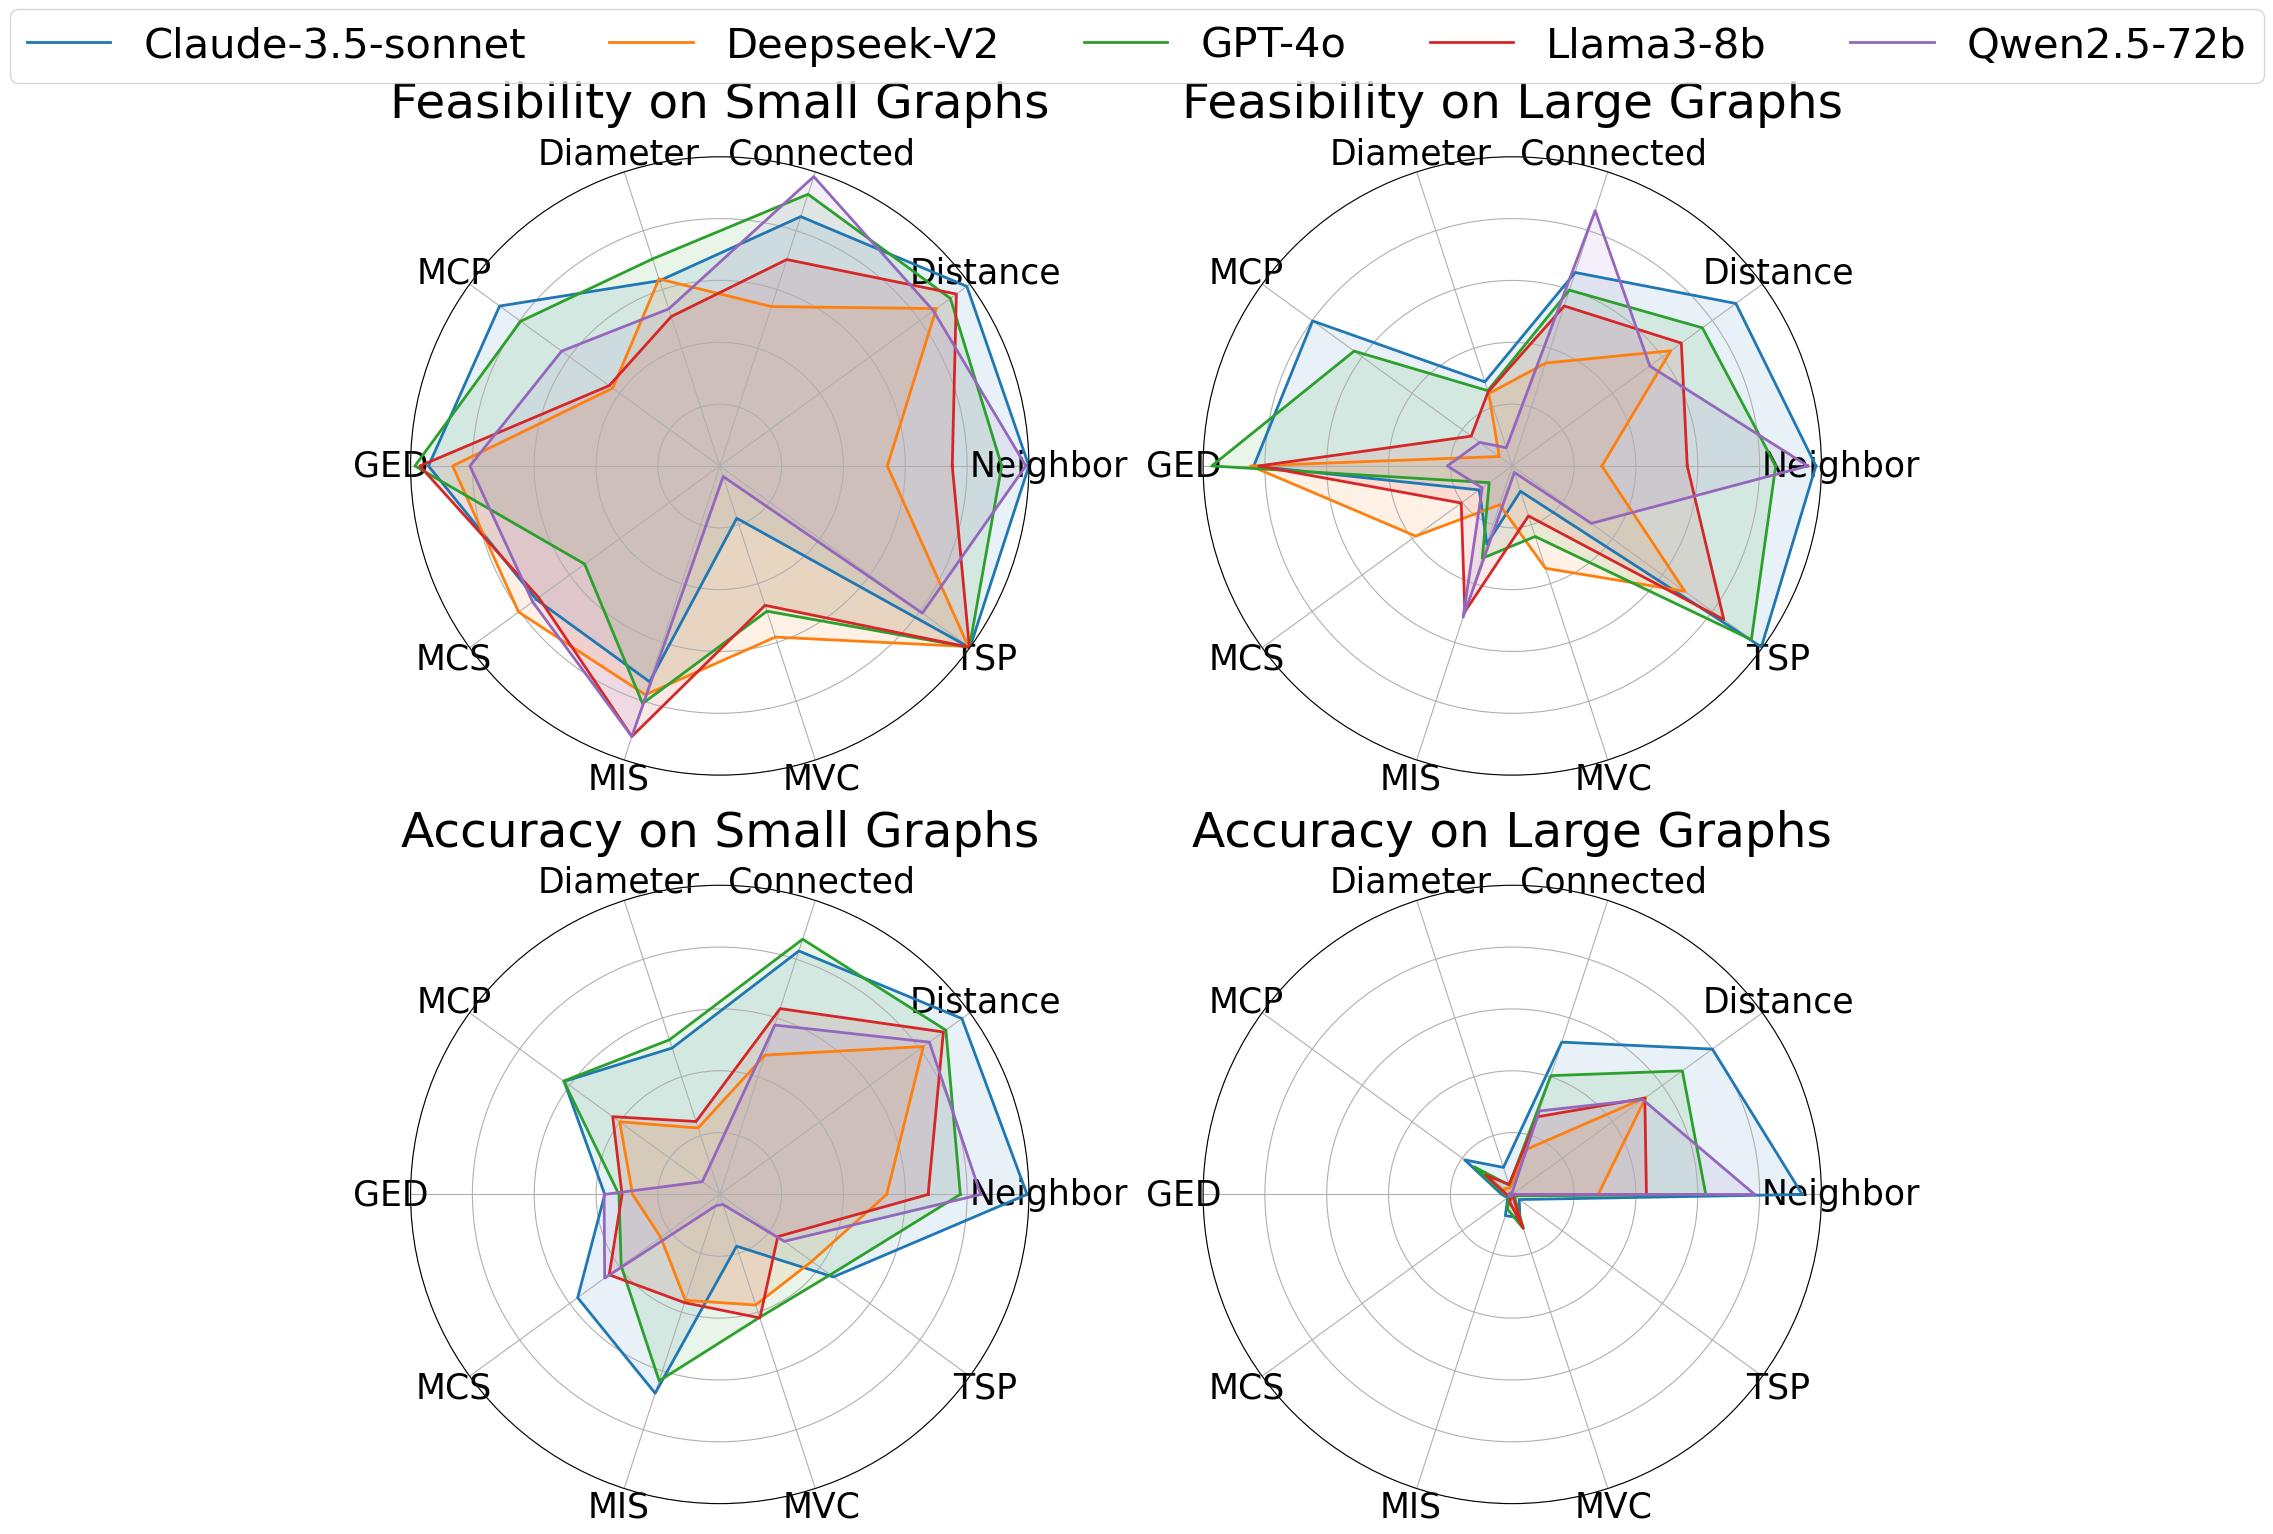

In [7]:
# plt.rcParams['font.family'] = 'Times New Roman'
average_metrics = defaultdict(lambda: defaultdict(dict))
df['Model']
for model in df['Model'].unique():
    model_list = 'gpt4,gpt4mini,claude,glm,llama,llama8b,deepseek,qwen72b,mixtral,gemma'.split(',')
    if model not in ['gpt4','deepseek','claude','llama','qwen72b'] or model not in model_list:
    # if model in ['gpt4','deepseek','claude','llama','qwen72b'] or model not in model_list:  # for figure 8 in appendix
        continue
    for task in df['Task'].unique():
        task_data = df[(df['Model'] == model) & (df['Task'] == task)]
        if not task_data.empty:
            average_metrics[model][task] = {
                'Feasibility on Small Graphs': task_data['feasible-easy'].mean(),
                'Accuracy on Small Graphs': task_data['acc-easy'].mean(),
                'Feasibility on Large Graphs': task_data['feasible-hard'].mean(),
                'Accuracy on Large Graphs': task_data['acc-hard'].mean()
            }

def reorder_metrics(metrics, order):
    reordered = {}
    for task in order:
        if task in metrics:
            reordered[task] = metrics[task]
    return reordered

def plot_and_save_radar_chart_for_all_metrics(filename):
    tasks = task_order
    N = len(tasks)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, axes = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(polar=True))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        metric_name = metrics_to_plot[i]
        for model in average_metrics.keys():
            metrics = reorder_metrics(average_metrics[model], task_order)
            values = [metrics[task][metric_name] for task in tasks]
            values += values[:1] 
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
            ax.fill(angles, values, alpha=0.1)  

        ax.set_ylim(0, 1.0)

        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(tasks, fontsize=25)
        ax.set_title(f'{metric_name}', size=35, y=1.05)

    handles, labels = axes[0].get_legend_handles_labels()
    for i in range(len(labels)):
        if labels[i] == 'llama':
            labels[i] = 'Llama3-8b'
        elif labels[i] == 'claude':
            labels[i] = 'Claude-3.5-sonnet'
        elif labels[i] == 'deepseek':
            labels[i] = 'Deepseek-V2'
        elif labels[i] == 'qwen72b':
            labels[i] = 'Qwen2.5-72b'
        elif labels[i] == 'gpt4':
            labels[i] = 'GPT-4o'
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fancybox=True, fontsize=30)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

metrics_to_plot = ['Feasibility on Small Graphs', 'Feasibility on Large Graphs', 'Accuracy on Small Graphs', 'Accuracy on Large Graphs']
plot_and_save_radar_chart_for_all_metrics('all_radar_charts_appendix.pdf')